In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from gurobipy import *
import osmnx as ox
ox.config(use_cache=True, log_console=True)
import math as math
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Albstadt Candidates from FLM

#The following Pickup-Points are established:
#-290847730; Coordinates: 48.2554692, 9.0136856
#-366360585; Coordinates: 48.2110663, 9.022576
#-293003525; Coordinates: 48.2304419, 8.9677358
#-248746221; Coordinates: 48.237164, 9.027823
#-262388012; Coordinates: 48.222982, 8.9184284
#-255887075; Coordinates: 48.2827414, 9.001414

In [3]:
# Number of Candidate DCs chosen from Facility Location Model
DC_N = 5

# List Creator for DCs
def createList_DC(r1, r2):
    return list(['DC%d'%x for x in range(r1, r2+1)])

#create an index
DC_ID = createList_DC(1, DC_N)

#Gi = fixed cost for establishing depot i
fixed_cost_DC = [150] * DC_N 

#Maximum Throughput at depot i = Vi
capacity_DC = [100] * DC_N

#Variable Warehousing Cost (Picking)
varCost_DC = [0.5, 0.4, 0.2, 0.8, 0.1]

#Position of the DCs
lat_DC = [48.2554692, 48.2110663, 48.2304419, 48.237164, 48.222982]
lon_DC = [9.0136856, 9.022576, 8.9677358, 9.027823, 8.9184284]

# Osmid of the Dcs
osmid = [290847730, 366360585, 293003525, 248746221, 262388012]

dc_tuples = list(zip(DC_ID, fixed_cost_DC, capacity_DC, varCost_DC, lat_DC, lon_DC, osmid))

set_of_all_DC = pd.DataFrame(dc_tuples, columns = ["DC_ID", "fixed_cost_DC", "capacity_DC", "varCost_DC", "lat", "lon", "osmid"])
set_of_all_DC.set_index("DC_ID", inplace = True)

# Define Index I for model building
I = set_of_all_DC.index.values

# DC_S
DC_S = set_of_all_DC["osmid"].values.tolist()

set_of_all_DC

,fixed_cost_DC,capacity_DC,varCost_DC,lat,lon,osmid
DC_ID,,,,,,
DC1,150,100,0.5,48.255469,9.013686,290847730
DC2,150,100,0.4,48.211066,9.022576,366360585
DC3,150,100,0.2,48.230442,8.967736,293003525
DC4,150,100,0.8,48.237164,9.027823,248746221
DC5,150,100,0.1,48.222982,8.918428,262388012


In [4]:
# Sample Customers from osmnx

# Define Customer N and Demand per
customers = 25
demand_per_customer = 5

# Function to create a Customer Index List
def createList_C(r1, r2):
    return list(['C%d'%x for x in range(r1, r2+1)])

# Get all nodes in Würzburg from OSMNX which will be used to sample a certain amount of customers
G = ox.graph_from_place("Albstadt, Germany", network_type = "drive")
Gs = ox.utils_graph.get_largest_component(G, strongly = True)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(Gs)

# Create nodes_df which is the basis for our customer df
nodes_df = gdf_nodes[["y", "x"]].copy()
nodes_df.columns = ["lat", "lon"]

#Sample from nodes_df
sample_nodes_df = nodes_df.sample(n = customers, random_state= 3)


#DF Manipulation
C_ID = createList_C(1,customers)
osmid = list(sample_nodes_df.index.values)
sample_nodes_df = sample_nodes_df.rename(index=dict(zip(osmid,C_ID)))
sample_nodes_df.index.name = "C_ID"
sample_nodes_df["osmid"] = osmid

#Create final demand column for customer DF
mylist = [demand_per_customer] * customers

set_of_all_customers = sample_nodes_df.copy()
# Add Demand column from the newly created list
set_of_all_customers['Demand_C'] = mylist
# Sort the df by osmid, this needs to be done for renaming purposes in the dist_matrix
set_of_all_customers = set_of_all_customers.sort_values(by=["osmid"])
# New index C1-C2 etc.
set_of_all_customers.reset_index(drop=True, inplace=True)
set_of_all_customers.index = C_ID
set_of_all_customers.index.names = ["C_ID"]
# Create Nodes_S for joining and plotting later
Nodes_S = set_of_all_customers["osmid"].tolist()
# Create index J for model building
J = set_of_all_customers.index.values
set_of_all_customers.head()

,lat,lon,osmid,Demand_C
C_ID,,,,
C1,48.208050,9.020096,254317014,5
C2,48.288527,8.991621,255558685,5
C3,48.286789,9.000288,259869330,5
C4,48.287248,8.999207,259869331,5
C5,48.285485,8.996243,259873252,5


In [5]:
Nodes_S = set_of_all_customers["osmid"].tolist()
Nodes_S1 = DC_S + Nodes_S
# By combining the lists in this way, the DCs are first and customers second
#Nodes_S1

In [6]:
# Construct set of all vehicles K

#Vehicle Count
V_N = 3

# Vehicle List Creator
def createList_V(r1, r2):
    return list(['V_%d'%x for x in range(r1, r2+1)])

# create index
V_ID = createList_V(1, V_N)

# Vehicle Capacity Qk
capacity_V = [50] * V_N

# fixed cost of using Vehicle Fk
fixed_cost_V = [50] * V_N

v_tuples = list(zip(V_ID, capacity_V, fixed_cost_V))

set_of_all_vehicles = pd.DataFrame(v_tuples, columns = ["V_ID", "capacity_V", "fixed_cost_V"])
set_of_all_vehicles.set_index("V_ID", inplace=True)
K = set_of_all_vehicles.index.values
set_of_all_vehicles

,capacity_V,fixed_cost_V
V_ID,,
V_1,50,5
V_2,50,5
V_3,50,5


In [7]:
# Create full Distance Matrix from which we can sample the Customers/PuPs
G = ox.graph_from_place("Albstadt, Germany", network_type = "drive")
Gs = ox.utils_graph.get_largest_component(G, strongly = True)
mat_generator = nx.all_pairs_dijkstra_path_length(Gs, weight = "length")
mat_dict = dict(mat_generator)
mat = pd.DataFrame(mat_dict).round(1)
mat = mat.rename_axis("osmid").sort_values(by = ["osmid"])
mat.head()

,30333648,54430983,54430996,54431038,54431056,54431063,54431070,54431198,54431234,55390213,...,7560535658,7560535659,7560535669,7560535672,7560535673,7629497091,8066894711,8066894725,8235283535,8482290336
osmid,,,,,,,,,,,,,,,,,,,,,
30333648,0.0,6852.9,6929.0,7349.7,7046.1,6953.6,7085.7,7162.3,7318.7,7368.6,...,6286.2,6145.3,6056.2,5966.8,5945.1,11052.7,8224.2,7424.2,5456.8,11035.7
54430983,6711.4,0.0,80.6,623.9,307.8,215.3,347.4,605.3,761.7,811.6,...,5267.0,5126.2,5856.3,5767.0,5745.2,11891.5,9063.1,8263.0,5825.5,11874.5
54430996,6787.5,80.6,0.0,543.3,227.1,134.6,266.8,524.6,681.0,731.0,...,5347.7,5206.8,5937.0,5847.6,5825.8,11967.6,9139.2,8339.2,5901.6,11950.6
54431038,7208.2,623.9,543.3,0.0,316.2,408.7,276.5,368.9,328.3,278.4,...,5891.0,5750.1,6480.3,6390.9,6369.1,12388.3,9559.9,8759.9,6322.3,12371.3
54431056,6904.6,307.8,227.1,316.2,0.0,92.5,39.6,297.5,453.9,503.8,...,5574.8,5433.9,6164.1,6074.7,6053.0,12084.7,9256.3,8456.2,6018.7,12067.7


In [8]:
# Join Distances for the sampled nodes from our Initial Distance Matrix for all nodes 
dist_matrix_d = pd.DataFrame(index=Nodes_S1)
# Rename the index for the join with the distance matrix
dist_matrix_d = dist_matrix_d.rename_axis("osmid")
# Join new empty dist_matrix with filled matrix for every chosen node
dist_matrix_d = dist_matrix_d.merge(mat, left_index=True, right_index=True)
dist_matrix_d = dist_matrix_d[dist_matrix_d.columns.intersection(Nodes_S1)]
#Rename Columns to fit the order of Nodes_S1 = DCs first then Customers. Index and columns have to match in position
dist_matrix_d = dist_matrix_d.reindex(columns=Nodes_S1)

# Have to replace column names and index values with more paletable values (osmids could confuse, need DC1 C1 etc.). Use the I and J arrays from Customer and DC Dataframes to form a list
nn = np.concatenate((I,J), axis=None)
new_colnames = nn.tolist()
dist_matrix_d.columns = new_colnames
dist_matrix_d.index = new_colnames
dist_matrix_d.head()

,DC1,DC2,DC3,DC4,DC5,C1,C2,C3,C4,C5,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
DC1,0.0,5559.8,6330.1,2469.6,11625.4,5998.2,4469.1,4217.7,4136.9,3901.2,...,6918.2,2906.7,12162.7,4338.1,4580.3,3712.1,3306.5,256.9,3558.7,89.3
DC2,5565.1,0.0,5669.8,3131.5,8355.2,438.5,9812.5,9561.1,9480.2,9244.6,...,1939.2,2661.1,8892.5,1477.5,9919.7,4707.0,4010.5,5605.8,8225.0,5503.2
DC3,6136.4,5639.3,0.0,8115.6,5295.3,5778.9,9821.1,10300.3,10219.5,9868.3,...,7578.6,8056.7,5832.6,6873.1,10673.1,6983.2,8406.5,6393.3,9525.8,6225.7
DC4,2507.4,3090.2,8129.9,0.0,11320.9,3528.6,6754.9,6503.5,6422.6,6186.9,...,4448.6,437.1,11858.2,1868.5,6862.1,1649.4,952.9,2548.2,5167.3,2445.5
DC5,11416.1,8320.0,5279.7,11207.8,0.0,8293.7,15100.8,15580.0,15499.2,15148.0,...,10259.2,10737.4,887.4,9553.8,15952.8,12262.9,12086.8,11673.0,14805.5,11505.4


In [9]:
# Cost Factor Multiplication. Each Meter of Route has a certain cost
dist_matrix = dist_matrix_d * 0.0003
dist_matrix.head()

,DC1,DC2,DC3,DC4,DC5,C1,C2,C3,C4,C5,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
DC1,0.00000,1.66794,1.89903,0.74088,3.48762,1.79946,1.34073,1.26531,1.24107,1.17036,...,2.07546,0.87201,3.64881,1.30143,1.37409,1.11363,0.99195,0.07707,1.06761,0.02679
DC2,1.66953,0.00000,1.70094,0.93945,2.50656,0.13155,2.94375,2.86833,2.84406,2.77338,...,0.58176,0.79833,2.66775,0.44325,2.97591,1.41210,1.20315,1.68174,2.46750,1.65096
DC3,1.84092,1.69179,0.00000,2.43468,1.58859,1.73367,2.94633,3.09009,3.06585,2.96049,...,2.27358,2.41701,1.74978,2.06193,3.20193,2.09496,2.52195,1.91799,2.85774,1.86771
DC4,0.75222,0.92706,2.43897,0.00000,3.39627,1.05858,2.02647,1.95105,1.92678,1.85607,...,1.33458,0.13113,3.55746,0.56055,2.05863,0.49482,0.28587,0.76446,1.55019,0.73365
DC5,3.42483,2.49600,1.58391,3.36234,0.00000,2.48811,4.53024,4.67400,4.64976,4.54440,...,3.07776,3.22122,0.26622,2.86614,4.78584,3.67887,3.62604,3.50190,4.44165,3.45162


In [10]:
# Add a Time matrix so that we can incorporate traveling times into our routes and cost calculation
F = ox.graph_from_place("Albstadt, Germany", network_type = "drive")
Fs = ox.utils_graph.get_largest_component(F, strongly = True)
Fs = ox.add_edge_speeds(Fs)
Fs = ox.add_edge_travel_times(Fs)
#by specifying weight = travel_time, the output is travel time between the nodes in seconds
mat_generator1 = nx.all_pairs_dijkstra_path_length(Fs, weight = "travel_time")
mat_dict1 = dict(mat_generator1)
mat1 = pd.DataFrame(mat_dict1).round(1)
mat1 = mat1.rename_axis("osmid").sort_values(by = ["osmid"])
mat1.head()

,30333648,54430983,54430996,54431038,54431056,54431063,54431070,54431198,54431234,55390213,...,7560535658,7560535659,7560535669,7560535672,7560535673,7629497091,8066894711,8066894725,8235283535,8482290336
osmid,,,,,,,,,,,,,,,,,,,,,
30333648,0.0,455.7,461.0,513.6,476.0,469.9,480.5,495.3,514.1,520.1,...,465.6,455.5,454.8,446.8,444.8,754.4,561.9,516.9,417.6,811.9
54430983,454.7,0.0,5.3,57.9,20.3,14.2,24.8,39.6,58.4,64.4,...,316.8,306.7,365.0,357.0,355.0,764.5,584.8,539.8,385.0,834.8
54430996,460.0,5.3,0.0,52.6,15.0,8.9,19.5,34.3,53.1,59.1,...,322.1,312.0,370.3,362.3,360.3,769.8,590.1,545.1,390.3,840.1
54431038,512.6,57.9,52.6,0.0,37.6,43.7,33.1,37.2,39.4,33.4,...,374.7,364.6,422.9,414.9,412.9,822.4,642.7,597.7,442.9,892.7
54431056,475.0,20.3,15.0,37.6,0.0,6.1,4.5,19.3,38.1,44.1,...,337.1,327.0,385.3,377.3,375.3,784.8,605.1,560.1,405.3,855.1


In [11]:
# Join Travel Times for the sampled nodes from our Time Matrix for all nodes 
time_matrix_t = pd.DataFrame(index=Nodes_S1)
# Rename the index for the join with the time matrix
time_matrix_t = time_matrix_t.rename_axis("osmid")
# Join new empty time_matrix with filled matrix for every chosen node
time_matrix_t = time_matrix_t.merge(mat1, left_index=True, right_index=True)
time_matrix_t = time_matrix_t[time_matrix_t.columns.intersection(Nodes_S1)]
#Rename Columns to fit the order of Nodes_S1 = DCs first then Customers. Index and columns have to match in position
time_matrix_t = time_matrix_t.reindex(columns=Nodes_S1)

nn = np.concatenate((I,J), axis=None)
new_colnames = nn.tolist()
time_matrix_t.columns = new_colnames
time_matrix_t.index = new_colnames
time_matrix_t.head()

,DC1,DC2,DC3,DC4,DC5,C1,C2,C3,C4,C5,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
DC1,0.0,374.8,381.6,184.0,699.6,404.8,303.2,290.1,281.0,247.3,...,528.5,213.7,764.9,294.7,382.5,353.4,282.4,71.5,266.5,11.2
DC2,383.0,0.0,383.3,193.9,443.8,30.0,652.4,639.3,630.2,596.5,...,193.1,161.9,509.1,102.7,731.7,377.2,287.2,452.6,560.5,394.2
DC3,367.6,381.6,0.0,550.2,318.0,368.1,571.6,616.5,606.2,561.9,...,533.9,534.9,383.3,475.7,750.1,509.6,648.6,439.1,632.7,378.8
DC4,194.2,190.8,541.8,0.0,634.6,220.8,463.6,450.5,441.4,407.7,...,344.5,29.7,699.9,110.7,542.9,188.4,98.4,263.8,371.7,205.4
DC5,685.2,442.1,317.6,629.0,0.0,425.9,889.2,934.1,923.8,879.5,...,591.7,597.0,84.7,537.8,1067.7,812.3,722.3,756.7,950.3,696.4


In [12]:
# Add Service Time to the routes for every route from Customer to Customer or DC to customer (but not from Customer to DC)
service_time = 120 # 120 Seconds Service Time for a delivery should be reasonable
time_matrix_t[len(DC_S):len(DC_S)+len(Nodes_S)] = time_matrix_t[len(DC_S):len(DC_S)+len(Nodes_S)] + service_time
time_matrix_t.head()

,DC1,DC2,DC3,DC4,DC5,C1,C2,C3,C4,C5,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
DC1,0.0,374.8,381.6,184.0,699.6,404.8,303.2,290.1,281.0,247.3,...,528.5,213.7,764.9,294.7,382.5,353.4,282.4,71.5,266.5,11.2
DC2,383.0,0.0,383.3,193.9,443.8,30.0,652.4,639.3,630.2,596.5,...,193.1,161.9,509.1,102.7,731.7,377.2,287.2,452.6,560.5,394.2
DC3,367.6,381.6,0.0,550.2,318.0,368.1,571.6,616.5,606.2,561.9,...,533.9,534.9,383.3,475.7,750.1,509.6,648.6,439.1,632.7,378.8
DC4,194.2,190.8,541.8,0.0,634.6,220.8,463.6,450.5,441.4,407.7,...,344.5,29.7,699.9,110.7,542.9,188.4,98.4,263.8,371.7,205.4
DC5,685.2,442.1,317.6,629.0,0.0,425.9,889.2,934.1,923.8,879.5,...,591.7,597.0,84.7,537.8,1067.7,812.3,722.3,756.7,950.3,696.4


In [13]:
time_matrix = time_matrix_t * 0.0042
time_matrix.head()

,DC1,DC2,DC3,DC4,DC5,C1,C2,C3,C4,C5,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
DC1,0.00000,1.57416,1.60272,0.77280,2.93832,1.70016,1.27344,1.21842,1.18020,1.03866,...,2.21970,0.89754,3.21258,1.23774,1.60650,1.48428,1.18608,0.30030,1.11930,0.04704
DC2,1.60860,0.00000,1.60986,0.81438,1.86396,0.12600,2.74008,2.68506,2.64684,2.50530,...,0.81102,0.67998,2.13822,0.43134,3.07314,1.58424,1.20624,1.90092,2.35410,1.65564
DC3,1.54392,1.60272,0.00000,2.31084,1.33560,1.54602,2.40072,2.58930,2.54604,2.35998,...,2.24238,2.24658,1.60986,1.99794,3.15042,2.14032,2.72412,1.84422,2.65734,1.59096
DC4,0.81564,0.80136,2.27556,0.00000,2.66532,0.92736,1.94712,1.89210,1.85388,1.71234,...,1.44690,0.12474,2.93958,0.46494,2.28018,0.79128,0.41328,1.10796,1.56114,0.86268
DC5,2.87784,1.85682,1.33392,2.64180,0.00000,1.78878,3.73464,3.92322,3.87996,3.69390,...,2.48514,2.50740,0.35574,2.25876,4.48434,3.41166,3.03366,3.17814,3.99126,2.92488


<font size="6">**Define the Model**</font><br>
![Wu_New](https://i.imgur.com/DeVQzoi.png)<br>

![wu_model2](https://i.imgur.com/h6Dng6i.png)

In [14]:
m = Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-01-23


In [15]:
x = m.addVars([*I,*J],[*I,*J],K, name = "x", vtype=GRB.BINARY)
y = m.addVars(I, name = "y", vtype = GRB.BINARY)
z = m.addVars(I,J, name = "z", vtype = GRB.BINARY)

U = [(l,k) for l in J for k in K]
u = m.addVars(U, name = "u", vtype= GRB.CONTINUOUS)

In [16]:
m.update()

In [17]:
fixedCost_depot = quicksum(y[i] * set_of_all_DC.loc[i].fixed_cost_DC for i in I)

variableCosts_transp = quicksum([(dist_matrix.loc[i,j] + time_matrix.loc[i,j]) * x[i,j,k] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])

variableCosts_DC = quicksum(set_of_all_DC.loc[i].varCost_DC * z[i,j] * set_of_all_customers.loc[j].Demand_C for j in J for i in I)

fixedCost_vehicle = quicksum(x[i,j,k] * set_of_all_vehicles.loc[k].fixed_cost_V for i in I for j in J for k in K if i!=j)

In [18]:
obj = fixedCost_depot + variableCosts_transp + variableCosts_DC + fixedCost_vehicle

In [19]:
m.setObjective(obj, GRB.MINIMIZE)

<font size="6"> **Constraints**</font>

![wu_constraints](https://i.imgur.com/Rwjsrnx.png)

In [20]:
for j in J:
    m.addConstr(quicksum(x[i,j,k] for i in [*I,*J] for k in K if i!=j) == 1)
    
for k in K:
    m.addConstr(quicksum(set_of_all_customers.loc[j].Demand_C * x[i,j,k] for i in [*I,*J] for j in J if i!=j) <= set_of_all_vehicles.loc[k].capacity_V)
    
for l in J:
    for j in J:
        if l!=j:
            for k in K:
                m.addConstr(u[l,k] - u[j,k] + (len(set_of_all_customers) * x[l,j,k]) <= len(set_of_all_customers) -1)
                
for i in [*I,*J]:
    for k in K:
        m.addConstr(quicksum(x[i,j,k] for j in [*I,*J] if i!=j) - quicksum(x[j,i,k] for j in [*I,*J] if i!=j) == 0)
        

for k in K:
    m.addConstr(quicksum(x[i,j,k] for i in I for j in J) <= 1)
    
for i in I:
    m.addConstr(quicksum(z[i,j] * set_of_all_customers.loc[j].Demand_C for j in J) - (set_of_all_DC.loc[i].capacity_DC * y[i]) <= 0)
    
    
for i in I:
    for j in J:
        for k in K:
            m.addConstr(quicksum(x[i,u,k] + x[u,j,k] for u in [*I,*J]) - z[i,j] <= 1)
            
# New Constraints, to ensure that y[i], the opening of depots works            
for i in I:
    for k in K:
        m.addConstr(quicksum(x[i,j,k] for j in J) <= y[i])
          
# At least one depot has to be opened        
m.addConstr(quicksum(y[i] for i in I) >= 1)

#new zij 
for j in J:
    m.addConstr(quicksum(z[i,j] for i in I) == 1)

for i in I:
    for j in J:
        m.addConstr(quicksum(x[i,j,k] for k in K) <= z[i,j])
        
# New Cap Constraint which should tell the model immediately how many DCs should be opened
# Only works like this if all DCs have the same capacity, if DCs have different capacities just change the "==" to "<="
#m.addConstr(quicksum(y[i] for i in I) <= math.ceil(sum(set_of_all_customers.loc[j].Demand_C for j in J)/(sum(set_of_all_DC.loc[i].capacity_DC for i in I))*DC_N))

In [21]:
# try new capacity constraint

#m.addConstr(quicksum(y[i] * set_of_all_DC.loc[i].capacity_DC for i in I) >= quicksum(set_of_all_customers.loc[j].Demand_C for j in J))

In [22]:
m.write("try.lp")

In [21]:
m.Params.MIPGap = 0.07
m.Params.MIPFocus = 2
m.Params.TimeLimit = 600
#m.read("tune_time0.prm")
m.update()

Set parameter MIPGap to value 0.07
Set parameter MIPFocus to value 2
Set parameter TimeLimit to value 600


In [22]:
m.Params.LogFile = "gurobi_log50.log"
m.update()
m.optimize()

Set parameter LogFile to value "gurobi_log50.log"
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2467 rows, 2905 columns and 38995 nonzeros
Model fingerprint: 0xf312bbb3
Variable types: 75 continuous, 2830 integer (2830 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [5e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 0 rows and 90 columns
Presolve time: 0.17s
Presolved: 2467 rows, 2815 columns, 38245 nonzeros
Variable types: 75 continuous, 2740 integer (2740 binary)
Root relaxation presolved: 2467 rows, 2815 columns, 38245 nonzeros


Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 2.492061e+02, 114 iterations, 0.03 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

In [23]:
m.printAttr("x")


    Variable            x 
-------------------------
x[DC3,C14,V_2]            1 
x[DC5,C6,V_3]            1 
x[DC5,C25,V_1]            1 
x[C1,C18,V_1]            1 
x[C2,C12,V_3]            1 
x[C3,C2,V_3]            1 
x[C4,C3,V_3]            1 
x[C5,C4,V_3]            1 
x[C6,C22,V_3]            1 
x[C7,C20,V_3]            1 
x[C8,C9,V_2]            1 
x[C9,C15,V_2]            1 
x[C10,C17,V_1]            1 
x[C11,C10,V_1]            1 
x[C12,DC5,V_3]            1 
x[C13,C8,V_2]            1 
x[C14,C13,V_2]            1 
x[C15,DC3,V_2]            1 
x[C16,C1,V_1]            1 
x[C17,C19,V_1]            1 
x[C18,DC5,V_1]            1 
x[C19,C16,V_1]            1 
x[C20,C5,V_3]            1 
x[C21,C7,V_3]            1 
x[C22,C21,V_3]            1 
x[C23,C24,V_1]            1 
x[C24,C11,V_1]            1 
x[C25,C23,V_1]            1 
      y[DC3]            1 
      y[DC5]            1 
   z[DC3,C8]            1 
   z[DC3,C9]            1 
  z[DC3,C13]            1 
  z[DC3,C14]     

In [24]:
# DC Printer
print("The following DCs are established:")
for i in I:
    if y[i].X >= 0.1:
        print("-{}".format(set_of_all_DC.loc[i].name))

The following DCs are established:
-DC3
-DC5


In [25]:
# new cost printer
fixedDC = sum([y[i].X * set_of_all_DC.loc[i].fixed_cost_DC for i in I])
dist_d = sum([x[i,j,k].X *  dist_matrix_d.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])
time_t = sum([x[i,j,k].X * time_matrix_t.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])
time_cost = sum([x[i,j,k].X * time_matrix.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])
var_dist = sum([x[i,j,k].X *  dist_matrix.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])
fixed_vehicle = sum([x[i,j,k].X * set_of_all_vehicles.loc[k].fixed_cost_V for i in I for j in J for k in K])
varDC = sum(set_of_all_DC.loc[i].varCost_DC * z[i,j].X * set_of_all_customers.loc[j].Demand_C for j in J for i in I)
TotalCost = time_cost + var_dist + fixed_vehicle + varDC + fixedDC
print("Distance traveled: {}m - in km {} \nTransportation Cost {}€".format(dist_d.round(1), (dist_d/1000).round(1), var_dist.round(1)))
print("Time elapsed on the routes {}s - in Minutes: {}".format(time_t.round(1), (time_t/60).round(1)))
print("Time based cost {}€".format(time_cost.round(1)))
print("Fixed Costs for Depots: {}€ \nVariable Warehousing Cost {}€ \nFixed Vehicle Cost {}€".format(fixedDC, varDC, fixed_vehicle))
print("Total Cost: {}€".format(TotalCost.round(1)))

Distance traveled: 100431.3m - in km 100.4 
Transportation Cost 30.1€
Time elapsed on the routes 10172.6s - in Minutes: 169.5
Time based cost 42.7€
Fixed Costs for Depots: 300.0€ 
Variable Warehousing Cost 15.0€ 
Fixed Vehicle Cost 15.0€
Total Cost: 402.9€


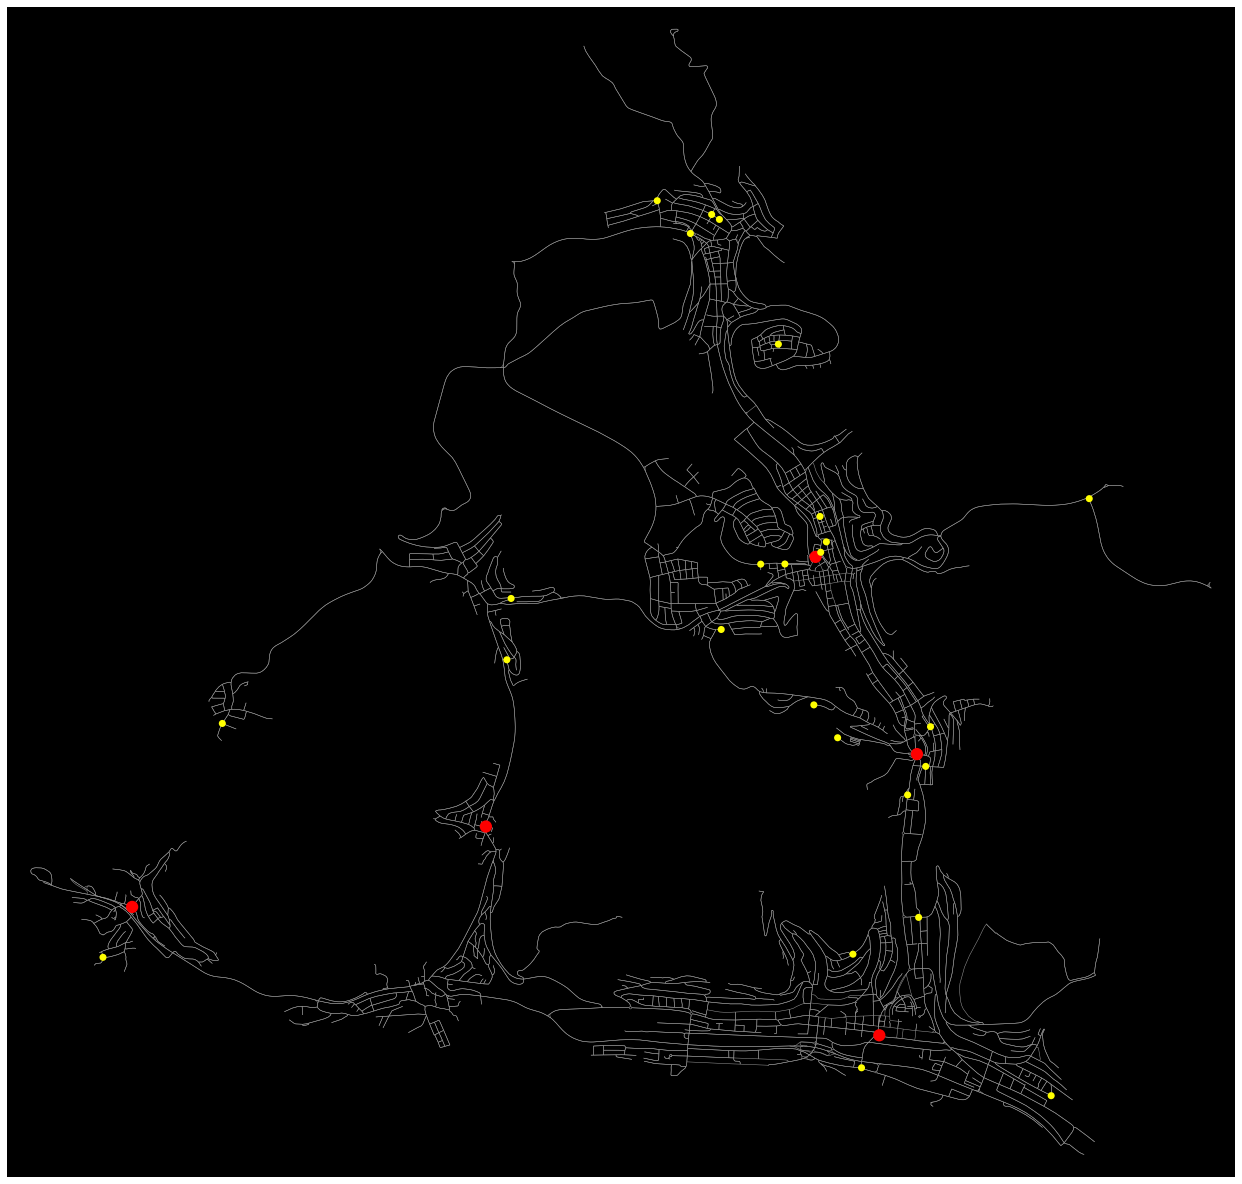

In [26]:
# First show the potential DCs and Customers
#warnings.filterwarnings("ignore")

place = {"city": "Albstadt", "country": "Germany"}
G = ox.graph_from_place(place, network_type = "drive")


nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

ns = []
for node in G.nodes():
    if node in DC_S:
        ns.append(150)
    elif node in Nodes_S:
        ns.append(50)
    else:
        ns.append(0)
        
nc = []
for node in G.nodes():
    if node in DC_S: 
        nc.append("red")
    elif node in Nodes_S:
        nc.append("yellow")
    else:
        nc.append("white")

        

fig, ax = ox.plot_graph(G, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

In [27]:
# Stop Counter
for k in K:
    r_c = sum([x[i,j,k].X for i in [*I,*J] for j in [*I,*J]])
    print(" Vehicle {} has {} stops on its route".format(k, r_c))

 Vehicle V_1 has 11.0 stops on its route
 Vehicle V_2 has 6.0 stops on its route
 Vehicle V_3 has 11.0 stops on its route


In [28]:
# Router Order Printer: This one works DC1 (DC has to be hardcoded)
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)
for i, tup in enumerate(selected.select("DC1", "*", "*")):
    k = tup[2]
    print("Route for Vehicle {}: {}".format(k, "DC1"), end = "")
    next_stop = tup[1]
    while next_stop:
        if next_stop == "DC1":
            break
        else:
            print(" -> {}".format(next_stop), end="")
            next_stop = selected.select(next_stop, "*")[0][1]
    print(" -> DC1")
# Total Distances of the routes of each vehicle (includes vehicle that does not start from this DC)
for k in K:
    r_len = sum([x[i,j,k].X * dist_matrix_d.loc[i,j] for i in [*I,*J] for j in [*I,*J]]) 
    print("Total Distance {}m for Vehicle {}".format(r_len.round(1), k))  

Total Distance 37247.3m for Vehicle V_1
Total Distance 12714.1m for Vehicle V_2
Total Distance 50469.9m for Vehicle V_3


In [29]:
# This one works DC2, have to hardcode the DC
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)
for i, tup in enumerate(selected.select("DC2", "*")):
    k = tup[2]
    print("Route for Vehicle {}: {}".format(k, "DC2"), end = "")
    next_stop = tup[1]
    while next_stop:
        if next_stop == "DC2":
            break
        else:
            print(" -> {}".format(next_stop), end="")
            next_stop = selected.select(next_stop, "*")[0][1]
    print(" -> DC2")
    
# Total Distances of the routes of each vehicle (includes vehicle that does not start from this DC)
for k in K:
    r_len = sum([x[i,j,k].X * dist_matrix_d.loc[i,j] for i in [*I,*J] for j in [*I,*J]]) 
    print("Total Distance {}m for Vehicle {}".format(r_len.round(1), k))     

Total Distance 37247.3m for Vehicle V_1
Total Distance 12714.1m for Vehicle V_2
Total Distance 50469.9m for Vehicle V_3


In [30]:
# This one works DC3, have to hardcode the DC
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)
for i, tup in enumerate(selected.select("DC3", "*")):
    k = tup[2]
    print("Route for Vehicle {}: {}".format(k, "DC3"), end = "")
    next_stop = tup[1]
    while next_stop:
        if next_stop == "DC3":
            break
        else:
            print(" -> {}".format(next_stop), end="")
            next_stop = selected.select(next_stop, "*")[0][1]
    print(" -> DC3")
    
# Total Distances of the routes of each vehicle (includes vehicle that does not start from this DC)
for k in K:
    r_len = sum([x[i,j,k].X  * dist_matrix_d.loc[i,j] for i in [*I,*J] for j in [*I,*J]]) 
    print("Total Distance {}m for Vehicle {}".format(r_len.round(1), k)) 

Route for Vehicle V_2: DC3 -> C14 -> C13 -> C8 -> C9 -> C15 -> DC3
Total Distance 37247.3m for Vehicle V_1
Total Distance 12714.1m for Vehicle V_2
Total Distance 50469.9m for Vehicle V_3


In [35]:
# This one works DC3, have to hardcode the DC
Q = "DC5"
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)
for i, tup in enumerate(selected.select(Q, "*")):
    k = tup[2]
    print("Route for Vehicle {}: {}".format(k, Q), end = "")
    next_stop = tup[1]
    while next_stop:
        if next_stop == Q:
            break
        else:
            print(" -> {}".format(next_stop), end="")
            next_stop = selected.select(next_stop, "*")[0][1]
    print(" -> " +Q)
    
# Total Distances of the routes of each vehicle (includes vehicle that does not start from this DC)
for k in K:
    r_len = sum([x[i,j,k].X  * dist_matrix_d.loc[i,j] for i in [*I,*J] for j in [*I,*J]]) 
    print("Total Distance {}m for Vehicle {}".format(r_len.round(1), k)) 

Route for Vehicle V_3: DC5 -> C6 -> C22 -> C21 -> C7 -> C20 -> C5 -> C4 -> C3 -> C2 -> C12 -> DC5
Route for Vehicle V_1: DC5 -> C25 -> C23 -> C24 -> C11 -> C10 -> C17 -> C19 -> C16 -> C1 -> C18 -> DC5
Total Distance 37247.3m for Vehicle V_1
Total Distance 12714.1m for Vehicle V_2
Total Distance 50469.9m for Vehicle V_3


In [ ]:
# Try to automate routing
# build dataframe which has all the osmids for DCs and Customers
# Join this dataframe with the list of tuples for the routes
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)

In [37]:
dc_set = set_of_all_DC.reset_index(level = "DC_ID")
dc_set.drop(["fixed_cost_DC", "capacity_DC", "varCost_DC", "lat", "lon"], axis=1, inplace=True)
dc_set.rename(columns={"DC_ID": "ID"}, inplace=True)
dc_set

,ID,osmid
0,DC1,290847730
1,DC2,366360585
2,DC3,293003525
3,DC4,248746221
4,DC5,262388012


In [38]:
c_set = set_of_all_customers.reset_index(level = "C_ID")
c_set.drop(["Demand_C", "lat", "lon"], axis=1, inplace=True)
c_set.rename(columns={"C_ID": "ID"}, inplace=True)
c_set.head()

,ID,osmid
0,C1,254317014
1,C2,255558685
2,C3,259869330
3,C4,259869331
4,C5,259873252


In [39]:
set_join = pd.concat([dc_set, c_set], axis=0)
set_join.head()

,ID,osmid
0,DC1,290847730
1,DC2,366360585
2,DC3,293003525
3,DC4,248746221
4,DC5,262388012


In [40]:
tuplol = list(selected)
mydf = pd.DataFrame(tuplol)

In [41]:
mydf.rename(columns={0: "Orig", 1: "Dest", 2: "V"}, inplace=True)
mydf.head()

,Orig,Dest,V
0,DC3,C14,V_2
1,DC5,C6,V_3
2,DC5,C25,V_1
3,C1,C18,V_1
4,C2,C12,V_3


In [42]:
joiner = pd.merge(mydf, set_join, left_on = "Orig", right_on = "ID")
joiner.drop(["ID"], axis=1, inplace=True)
joiner.rename(columns={"osmid": "orig_osmid"}, inplace=True)
joiner = pd.merge(joiner, set_join, left_on = "Dest", right_on = "ID")
joiner.drop(["ID"], axis=1, inplace=True)
joiner.rename(columns={"osmid": "dest_osmid"}, inplace=True)
joiner.head()

,Orig,Dest,V,orig_osmid,dest_osmid
0,DC3,C14,V_2,293003525,293009122
1,DC5,C6,V_3,262388012,263378025
2,DC5,C25,V_1,262388012,4327119895
3,C1,C18,V_1,254317014,329402234
4,C2,C12,V_3,255558685,288394486


In [43]:
def shortest_route(orig, dest):
    route = nx.shortest_path(Gs, source=orig, target=dest, weight= "length")                                 
    return route

In [44]:
joiner["route"] = joiner.apply(lambda x: shortest_route(x["orig_osmid"], x["dest_osmid"]), axis=1)
joiner.head()

,Orig,Dest,V,orig_osmid,dest_osmid,route
0,DC3,C14,V_2,293003525,293009122,"[293003525, 292290289, 292290539, 292289797, 2..."
1,DC5,C6,V_3,262388012,263378025,"[262388012, 329403093, 329403148, 329403116, 3..."
2,DC5,C25,V_1,262388012,4327119895,"[262388012, 329403093, 329403148, 329403116, 3..."
3,C1,C18,V_1,254317014,329402234,"[254317014, 254317011, 254315162, 7282064822, ..."
4,C2,C12,V_3,255558685,288394486,"[255558685, 2451035123, 255701238, 255889094, ..."


In [45]:
# All of the Routes / no distinction between vehicles
route_list = joiner["route"].tolist()

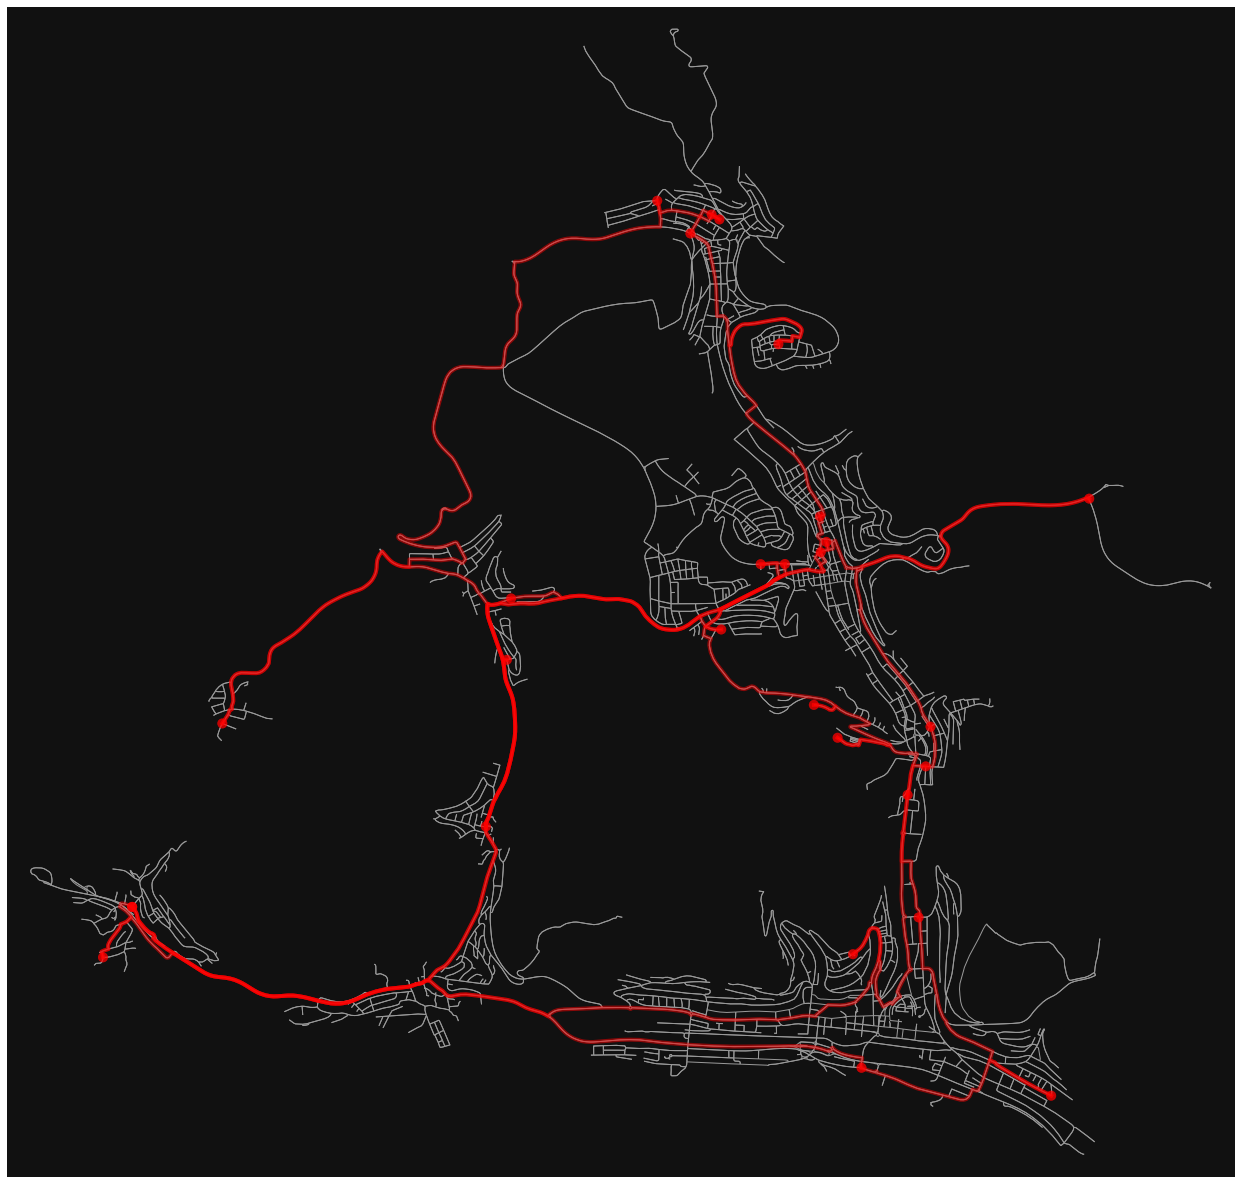

In [46]:
fig, ax = ox.plot_graph_routes(G, 
                               route_list, 
                               route_linewidth = 3, node_size = 0, figsize=(22,22))

In [47]:
# Have to split the routes into vehicles, this is for vehicle 1
v1 = joiner[joiner["V"]=="V_1"]
v1_routes = v1["route"].tolist()
len(v1_routes)

11

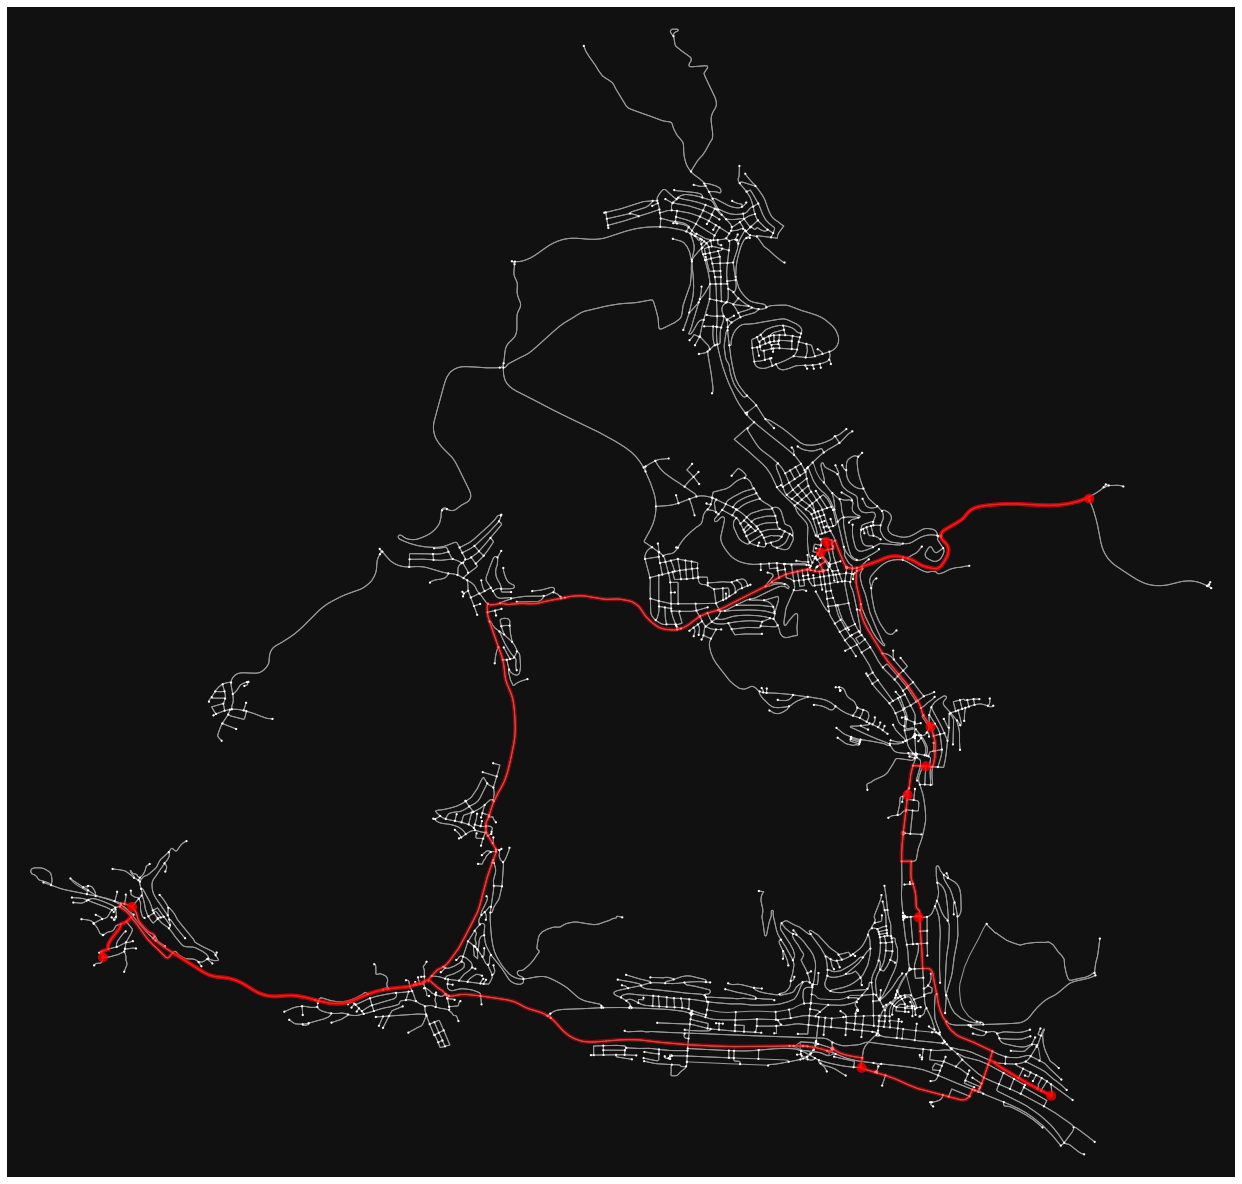

In [48]:
fig, ax = ox.plot_graph_routes(G, 
                               routes =v1_routes, route_color =["red"], # Vehicle 1 Yellows, V2 Red
                               route_linewidth= 4, node_size = 5, figsize=(22,22))

In [49]:
# To do further customization with node sizes/colors etc we need a list of all the nodes a Vehicle visits
v2 = joiner[joiner["V"]=="V_3"]
v2_routes = v2["route"].tolist()

In [50]:
v2_nodes_o= v2["orig_osmid"].tolist()
v2_nodes_d= v2["dest_osmid"].tolist()
v2_nodes = v2_nodes_o + v2_nodes_d
#v2_nodes

In [51]:
# Since the list always start with the DC, we can use loc[0] as condition for size increase when plotting
ns = []
for node in G.nodes():
    if node == v2_nodes[0]:
        ns.append(500)
    else:
        ns.append(0)

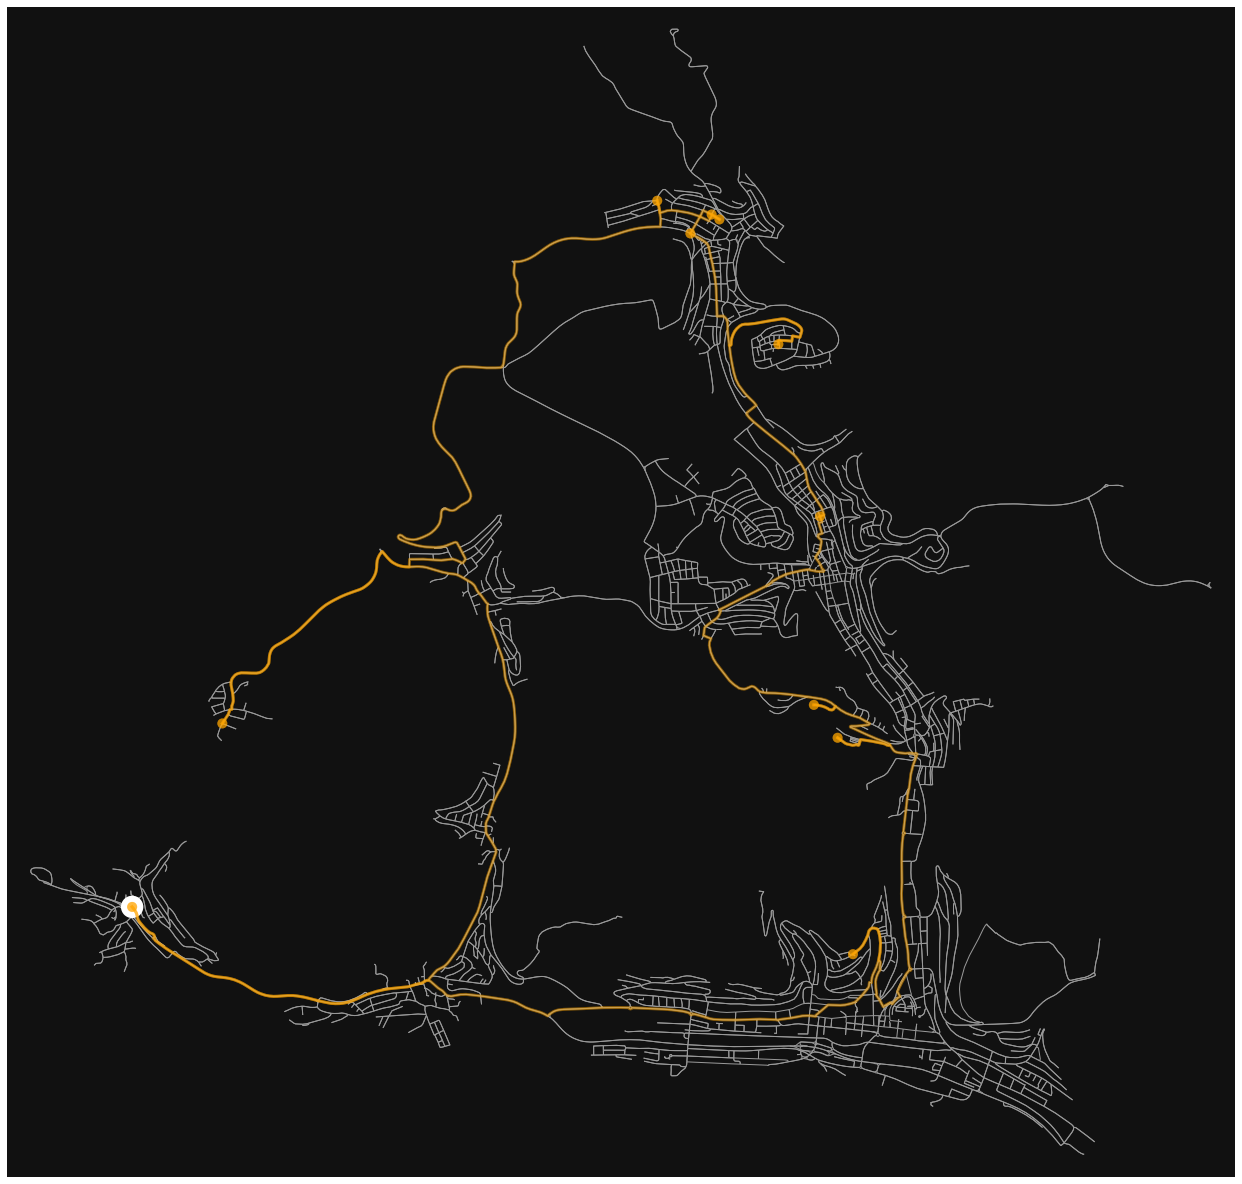

In [52]:
fig, ax = ox.plot_graph_routes(G, 
                               v2_routes, route_colors = "orange", route_linewidths = 3, node_size=ns,
                                  figsize=(22,22))